## Imports and Preparing Dataset Class

In [ ]:
import sys
sys.path.append("../")

from cv_expt.base.data.base_dataset import ImageDataset, ImageDataType
from cv_expt.base.defs.defs import ImageChannel, DataType
from cv_expt.base.logger.base_logger import BaseLogger, BaseLoggerConfig
from cv_expt.base.configs.configs import TrainerConfig, DataConfig
from cv_expt.vis.visualization import subplot_images
from cv_expt.base.logger.base_logger import BaseLogger
from cv_expt.base.models.base_model import ModelWrapper
from cv_expt.base.trainer.base_trainer import Trainer
from cv_expt.utils.histogram import hist_eq, my_hist

from pathlib import Path
from typing import Optional, Tuple, List
import torch
import cv2
import numpy as np
from tqdm import tqdm  # for progress bar
from torch import nn
from torch.optim import Optimizer
import segmentation_models_pytorch as smp
import datetime

class ImageCompletionDataConfig(DataConfig):
    patchify_rate: float = 0.9
    patch_hw_range: Tuple[int, int] = (50, 150)
    max_num_patches: int = 3
    min_avg_pixel_value: int = 100

class ImageCompletionDataset(ImageDataset):
    @staticmethod
    def random_patch_blank(image:np.ndarray, patch_hw_range:Tuple[int, int], blank_color:Tuple[int, int, int]=(0, 0, 0), num_patches:int=3, min_avg_pixel_value:int=100):
        h, w = image.shape[:2]
        if (w<patch_hw_range[1]) or (h < patch_hw_range[0]):
            return image
        for _ in range(num_patches):
            patch_h = np.random.randint(*patch_hw_range)
            patch_w = np.random.randint(*patch_hw_range)

            x = np.random.randint(0, w-patch_w)
            y = np.random.randint(0, h-patch_h)
            patch = image[y:y+patch_h, x:x+patch_w]
            if patch.mean() > min_avg_pixel_value:
                image[y:y+patch_h, x:x+patch_w] = blank_color
            else:
                num_patches += 1
        return image
         
    def __getitem__(self, idx):        
        if self.config.samples_per_epoch != -1 and idx == len(self)-1:
            self.random_state.shuffle(self.data)
        
        inp = self.get_item(idx)

        if self.config.label_path:
            target = self.get_label(idx)
        else:
            target = inp.copy()

        if self.random_state.uniform()>self.config.patchify_rate:
            image = inp  
        else:
            image = self.random_patch_blank(inp, self.config.patch_hw_range, num_patches=self.random_state.randint(self.config.max_num_patches))
        label = target

        image = cv2.resize(image, self.input_size)
        label = cv2.resize(label, self.input_size)

        if self.transforms:
            image = self.transforms(image)
            label = self.transforms(label)

        if self.normalization:
            image = self.normalization(image)
            label = self.normalization(label)

        # if return_type is tensor, convert the image to tensor
        if self.return_type == ImageDataType.TENSOR:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            # because the image is grayscale, we need to add the channel dimension
            label = torch.tensor(label, dtype=torch.float32).permute(2, 0, 1)

        return image, label

def normalization(x):
    return x / 255.0

def denormalization(x):
    return x * 255.0

# random seed should be same for both
data_config = ImageCompletionDataConfig(
    data_path=Path("../assets/training_data/val2017"),
    image_channels=ImageChannel.RGB,
    image_extensions=["jpg", "png"],
    max_data=-20,
    samples_per_epoch=1000,
)
val_data_config = ImageCompletionDataConfig(
    data_path=Path("../assets/training_data/val2017"),
    image_channels=ImageChannel.RGB,
    image_extensions=["jpg", "png"],
    max_data=-20,
    samples_per_epoch=100,
)
train_dataset = ImageCompletionDataset(
    data_config,
    return_type=ImageDataType.TENSOR,
    normalization=normalization,
    denormalization=denormalization,
)
val_dataset = ImageCompletionDataset(
    val_data_config,
    data_type=DataType.VALIDATION,
    return_type=ImageDataType.TENSOR,
    normalization=normalization,
    denormalization=denormalization,
)

### Sample Images

In [ ]:
import matplotlib.pyplot as plt

for i in np.random.randint(0, len(train_dataset), 5):
    inp, target = denormalization(train_dataset[i][0].permute(1,2,0).numpy()).astype(np.uint8),denormalization(train_dataset[i][1].permute(1,2,0).numpy()).astype(np.uint8)
    subplot_images([inp, target], ["Input", "Target"], order = (-1,2))
    plt.show()

## Model and Training

In [31]:
class CustomTrainer(Trainer):
    def visualize_output(self, sample, inputs, outputs, targets):
        images = []
        titles = []
                                    
        for _, (inp, output, target) in enumerate(
            zip(inputs, outputs, targets)
        ):
            if sample == self.config.display_samples_per_epoch:
                break

            inp = self.model.postprocess_output(inp).astype(np.uint8)
            output = self.model.postprocess_output(output).astype(np.uint8)
            target = self.model.postprocess_output(target).astype(np.uint8)
            images.extend(
                [
                    inp,
                    target,
                    output,
                ]
            )
            titles.extend(["Input", "Target", "Output"])
    
            sample += 1
        return images, titles, sample

config = TrainerConfig(
    result_dir=Path("../results"),
    expt_name="img_completion",
    run_name=f"run_{datetime.datetime.now().date()}",
    epochs=100,
    show_images=True,
    batch_size=32,
    
)
model = smp.Unet("resnet18", classes=3, in_channels=3, activation="sigmoid")
model = ModelWrapper(
    model,
    postprocess=val_dataset.denormalization,
    preprocess=val_dataset.normalization,
)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
trainer = CustomTrainer(
    model,
    config,
    optimizer,
    criterion,
    BaseLogger(BaseLoggerConfig(log_path=config.run_dir, name='img_completion', log_in_console=False)),
    train_dataset,
    val_dataset,
)

In [ ]:
trainer.train()

In [ ]:
trainer.best_model_path

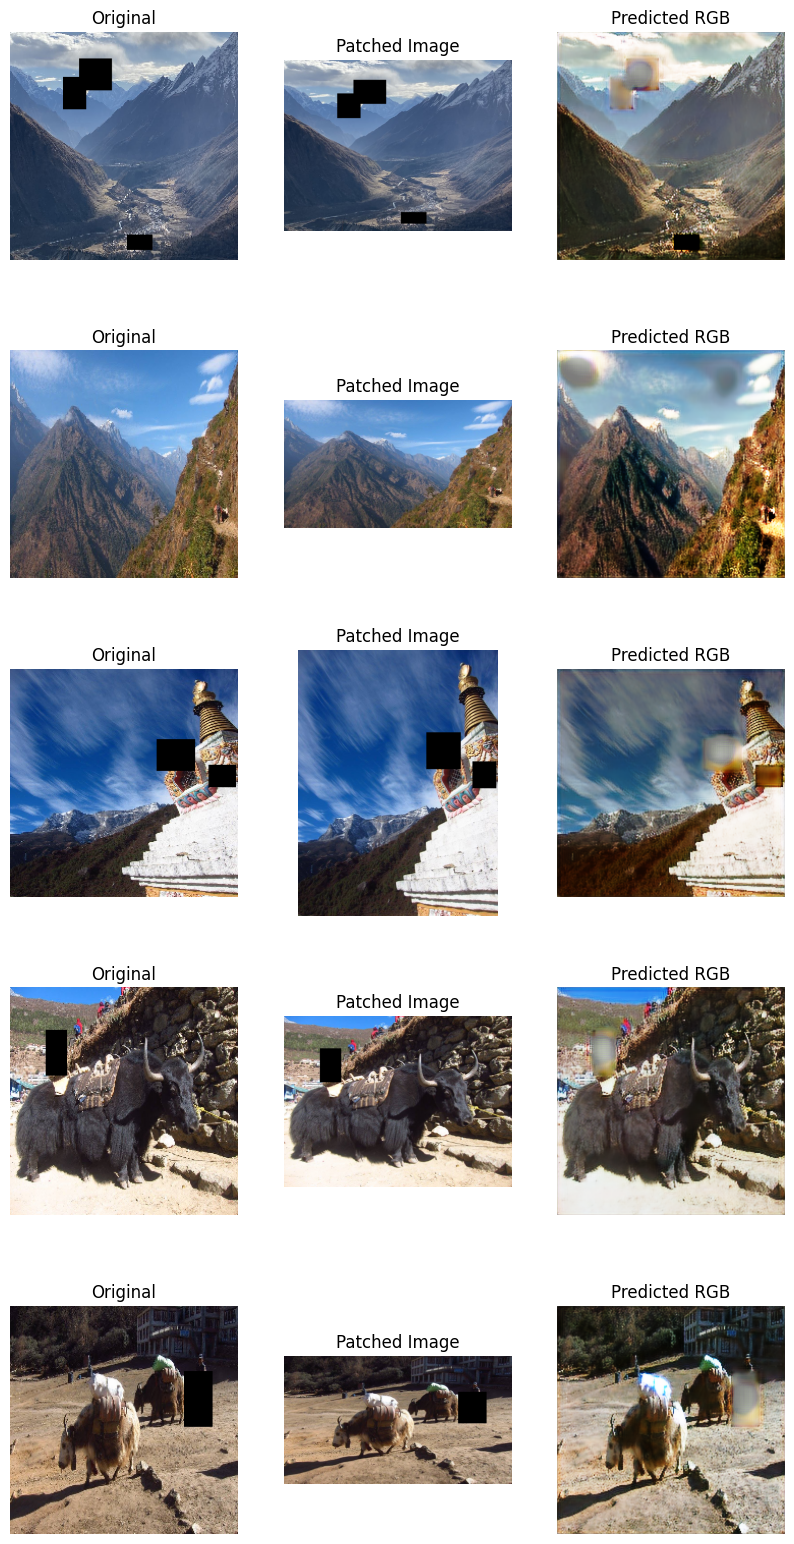

In [33]:
from cv_expt.utils.histogram import plot_hist
import matplotlib.pyplot as plt

loaded_model = torch.load(str(trainer.best_model_path))
test_root = Path("../data/test_images")
# test_root = Path("../data/coco2017/train2017")
images = []
titles=[]
max_data = 5
for i, test_img in enumerate(test_root.iterdir()):
    if i >= max_data:
        break
    rgb_img = cv2.imread(str(test_img))
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
    patched_image = val_dataset.random_patch_blank(rgb_img, val_dataset.config.patch_hw_range, num_patches=val_dataset.config.max_num_patches)

    rgb_img = cv2.resize(rgb_img, data_config.input_size[::-1])
    images.append(cv2.resize(rgb_img, data_config.input_size[::-1]))
    images.append(patched_image)
    img = rgb_img / 255.0
    img = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(0)
    # print(img.shape)
    pred = loaded_model(img.cuda())
    # print(pred.shape)
    pred = pred.squeeze(0)#.squeeze(0)
    pred = pred.detach().cpu().permute(1, 2, 0).numpy()
    
    pred = (denormalization(pred)).astype(np.uint8)
    images.append(pred)
    titles.extend(["Original", "Patched Image", "Predicted RGB"])
    plt.show()
    # break

from cv_expt.vis.visualization import subplot_images
subplot_images(images, order=(-1, 3), titles=titles, fig_size=(10, 20)).savefig(str(trainer.images_dir/"test_images.png"))